# Momentum resolution

In the following, all measurements are in metres, resp. radians.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Tracking resolution

### Single trajectory

??? implies that this is not fully solved:

Mainly: 
- is s0 an angle or a slope and should we predict the angle or the slope?
- Uncertainty (how to account for uncertainty of slope)

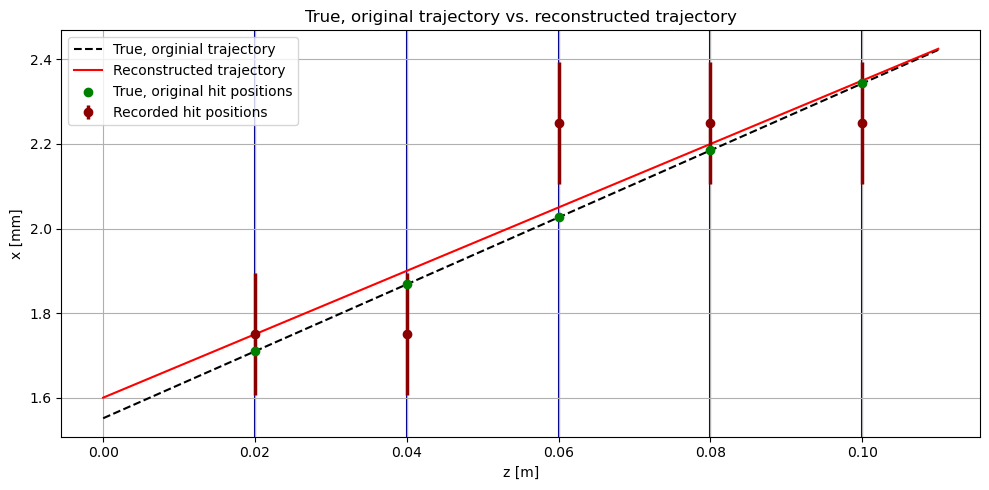

x0_true = 1.551 mm, s0_true = 0.008 rad
x0_reco = 1.600 mm ± 0.151 mm
s0_reco = 0.007 ± 0.002 rad


In [58]:
n_planes = 5
delta_z = 0.02  # 2 cm in metres
cell_width = 0.0005  # 500 micrometers in metres

np.random.seed(14)

x0_true = np.random.normal(0, 0.001)
s0_true = np.random.normal(0, 0.1)

z0 = 0

# Calculate the z and x positions of the planes 
# To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
def trajectory_fun(z_position, x0, angle): 
    return x0 + z_position * np.tan(angle) # Calculating the vertical position using trigonometry

z_positions = np.arange(1, n_planes + 1) * delta_z
x_positions = trajectory_fun(z_positions, x0_true, s0_true) 

# Calculate which cell was hit
cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
cells_hit_middle = cells_hit * cell_width + cell_width / 2

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia
# Missing influence of the uncertainty of the spread of the slope/angle ???



# Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

x0_reco, s0_reco = popt
std_x0_reco, std_s0_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)


# Plotting
grid = np.linspace(0, z_positions[-1] + delta_z/2, num = 1001)
true_traj_z = trajectory_fun(grid, x0_true, s0_true)
reco_traj_z = trajectory_fun(grid, x0_reco, s0_reco)

plt.figure(figsize=(10,5))
for z in z_positions:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0) # Detector planes
# I multiplied everything by thousand such that the y-axis has millimetre values
plt.plot(grid, 1000*true_traj_z, "k--", label = "True, orginial trajectory") 
plt.plot(grid, 1000*reco_traj_z, "r-", label = "Reconstructed trajectory")
plt.scatter(z_positions, 1000*x_positions, color = "g", label = "True, original hit positions", zorder = 3)
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*std_hit, fmt = "o", color = "darkred", linewidth = 2.5, label = "Recorded hit positions")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.legend()
plt.title("True, original trajectory vs. reconstructed trajectory")
plt.tight_layout()
plt.show()


print(f"x0_true = {x0_true*1000:.3f} mm, s0_true = {s0_true:.3f} rad")
print(f"x0_reco = {x0_reco*1000:.3f} mm ± {std_x0_reco*1000:.3f} mm")
print(f"s0_reco = {s0_reco:.3f} ± {std_s0_reco:.3f} rad")



We modeled it with /sqrt(12) - but we neglected the multiple scattering part. Important to mention this!